In [1]:
# コード非表示 
from IPython.display import HTML

HTML("""
<button id="code-show-switch-btn">スクリプトを非表示にする</button>

<script>
var code_show = true;

function switch_display_setting() {
    var switch_btn = $("#code-show-switch-btn");
    if (code_show) {
        $("div.input").hide();
        code_show = false;
        switch_btn.text("スクリプトを表示する");
    }else {
        $("div.input").show();
        code_show = true;
        switch_btn.text("スクリプトを非表示にする");
    }
}

$("#code-show-switch-btn").click(switch_display_setting);
</script>
""")

# ライブラリ 

In [84]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# データ 

In [3]:
df = pd.read_csv('../output/online_retail.csv', encoding='shift-jis')

In [4]:
df.head()

,invoice_no,item_no,item_description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.tail()

,invoice_no,item_no,item_description,quantity,invoice_date,unit_price,customer_id,country
397919,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
397920,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
397921,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
397922,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
397923,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397924 entries, 0 to 397923
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   invoice_no        397924 non-null  int64  
 1   item_no           397924 non-null  object 
 2   item_description  397924 non-null  object 
 3   quantity          397924 non-null  int64  
 4   invoice_date      397924 non-null  object 
 5   unit_price        397924 non-null  float64
 6   customer_id       397924 non-null  float64
 7   country           397924 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 24.3+ MB


# 前処理

## user x item matrix 

In [7]:
# ピボットテーブルを作成
df_user_item_matrix = df.pivot_table(index='customer_id', columns='item_no', values='invoice_no', aggfunc='count')

In [8]:
# 欠損を補完
df_user_item_matrix.fillna(0, inplace=True)

In [19]:
# 購入フラグ作成
df_user_item_matrix = df_user_item_matrix.apply(lambda x: x>0)

In [20]:
df_user_item_matrix

item_no,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
customer_id,,,,,,,,,,,,,,,,,,,,,
12346.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12347.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12348.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
12349.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
12350.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
18281.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
18282.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# アソシエーション分析 

## アソシエーション 

In [21]:
# 支持度が高い映画の表示
freq_items = apriori(df_user_item_matrix, min_support=0.05, use_colnames=True)
freq_items.sort_values('support', ascending=False, inplace=True)
freq_items

,support,itemsets
95,0.203042,(22423)
262,0.197280,(85123A)
227,0.163171,(47566)
249,0.156257,(84879)
142,0.147499,(22720)
...,...,...
351,0.050012,"(23209, 85099B)"
176,0.050012,(23077)
105,0.050012,(22499)
175,0.050012,(22998)


In [22]:
# 最もSupport（支持度）が高いデータを確認
df[df['item_no'] == '22423']

,invoice_no,item_no,item_description,quantity,invoice_date,unit_price,customer_id,country
870,536477,22423,REGENCY CAKESTAND 3 TIER,16,2010-12-01 12:27:00,10.95,16210.0,United Kingdom
926,536502,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:36:00,12.75,16552.0,United Kingdom
1081,536525,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:54:00,12.75,14078.0,United Kingdom
1144,536528,22423,REGENCY CAKESTAND 3 TIER,1,2010-12-01 13:17:00,12.75,15525.0,United Kingdom
1186,536530,22423,REGENCY CAKESTAND 3 TIER,1,2010-12-01 13:21:00,12.75,17905.0,United Kingdom
...,...,...,...,...,...,...,...,...
396637,581425,22423,REGENCY CAKESTAND 3 TIER,1,2011-12-08 15:31:00,12.75,14796.0,United Kingdom
396940,581449,22423,REGENCY CAKESTAND 3 TIER,1,2011-12-08 17:37:00,12.75,12748.0,United Kingdom
396941,581449,22423,REGENCY CAKESTAND 3 TIER,1,2011-12-08 17:37:00,12.75,12748.0,United Kingdom
397246,581472,22423,REGENCY CAKESTAND 3 TIER,2,2011-12-08 19:55:00,12.75,15796.0,United Kingdom


In [23]:
# アソシエーションルールの計算（リフト値の高い順に表示）
rules = association_rules(freq_items, metric='lift', min_threshold=0.1)
rules.sort_values('lift', ascending=False, inplace=True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
199,"(22423, 22697)","(22699, 22698)",0.068449,0.062687,0.051625,0.754209,12.031293,0.047334,3.813450
198,"(22699, 22698)","(22423, 22697)",0.062687,0.068449,0.051625,0.823529,12.031293,0.047334,5.278789
205,(22698),"(22699, 22423, 22697)",0.073519,0.059691,0.051625,0.702194,11.763789,0.047236,3.157458
192,"(22699, 22423, 22697)",(22698),0.059691,0.073519,0.051625,0.864865,11.763789,0.047236,6.855958
197,"(22699, 22697)","(22423, 22698)",0.073980,0.059691,0.051625,0.697819,11.690494,0.047209,3.111744
...,...,...,...,...,...,...,...,...,...
225,(85099B),(85123A),0.146347,0.197280,0.051164,0.349606,1.772128,0.022292,1.234206
138,(84879),(85123A),0.156257,0.197280,0.054621,0.349558,1.771881,0.023794,1.234113
139,(85123A),(84879),0.197280,0.156257,0.054621,0.276869,1.771881,0.023794,1.166791
76,(22423),(85123A),0.203042,0.197280,0.060152,0.296254,1.501691,0.020096,1.140639


In [41]:
df[df['item_no'].isin(['22423', '22697', '22699', '22698'])]

,invoice_no,item_no,item_description,quantity,invoice_date,unit_price,customer_id,country
870,536477,22423,REGENCY CAKESTAND 3 TIER,16,2010-12-01 12:27:00,10.95,16210.0,United Kingdom
926,536502,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:36:00,12.75,16552.0,United Kingdom
1066,536523,22699,ROSES REGENCY TEACUP AND SAUCER,6,2010-12-01 12:50:00,2.95,12868.0,United Kingdom
1075,536524,22697,GREEN REGENCY TEACUP AND SAUCER,6,2010-12-01 12:51:00,2.95,17572.0,United Kingdom
1081,536525,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:54:00,12.75,14078.0,United Kingdom
...,...,...,...,...,...,...,...,...
397514,581495,22699,ROSES REGENCY TEACUP AND SAUCER,12,2011-12-09 10:20:00,2.95,14051.0,United Kingdom
397515,581495,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-12-09 10:20:00,2.95,14051.0,United Kingdom
397516,581495,22697,GREEN REGENCY TEACUP AND SAUCER,12,2011-12-09 10:20:00,2.95,14051.0,United Kingdom
397527,581495,22423,REGENCY CAKESTAND 3 TIER,10,2011-12-09 10:20:00,12.75,14051.0,United Kingdom


## ネットワークグラフ 

https://www.yutaka-note.com/entry/networkx

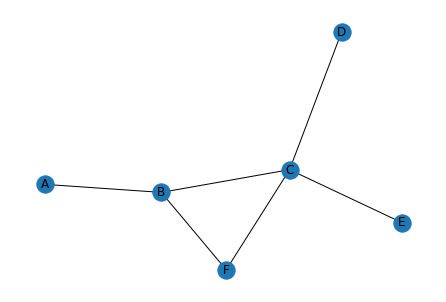

In [85]:
# Graphオブジェクトの作成
G = nx.Graph()
 
# nodeデータの追加
G.add_nodes_from(["A", "B", "C", "D", "E", "F"])
 
# edgeデータの追加
G.add_edges_from([("A", "B"), ("B", "C"), ("B", "F"),("C", "D"), ("C", "E"), ("C", "F"), ("B", "F")])
 
# ネットワークの可視化
nx.draw(G, with_labels = True)
plt.show()

In [86]:
print(nx.info(G))

Graph with 6 nodes and 6 edges


In [88]:
print('number of nodes:',G.number_of_nodes())
print('nodes:', G.nodes())

number of nodes: 6
nodes: ['A', 'B', 'C', 'D', 'E', 'F']


In [90]:
print('number of edges:',G.number_of_edges())
print('edges:', G.edges())

number of edges: 6
edges: [('A', 'B'), ('B', 'C'), ('B', 'F'), ('C', 'D'), ('C', 'E'), ('C', 'F')]


In [92]:
# print("degrees:", G.degrees())

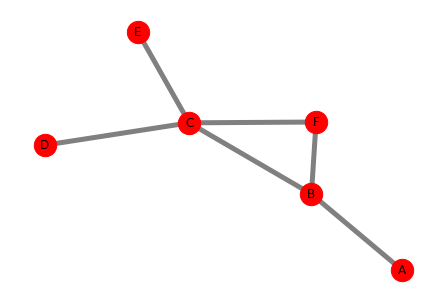

In [93]:
nx.draw(G, with_labels=True, node_color = "red", edge_color = "gray", node_size = 500, width = 5)
plt.show()

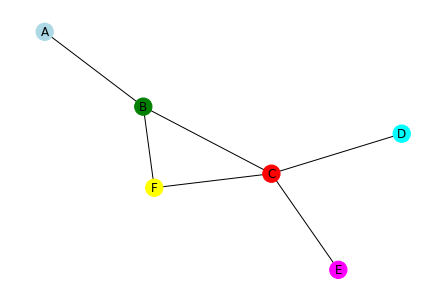

In [97]:
colors = ['lightblue', 'green', 'red', 'cyan', 'magenta', 'yellow']
nx.draw(G, with_labels=True, node_color = colors)

[150.0, 450.0, 600.0, 150.0, 150.0, 300.0]


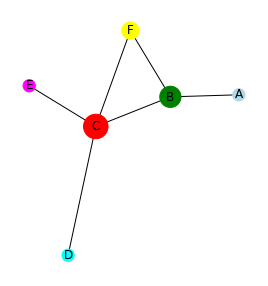

In [101]:
# ネットワーク全体の次数の平均値を計算
average_deg = sum(d for n, d in G.degree()) / G.number_of_nodes()
# ノードの次数に比例するようにサイズを設定
sizes = [300*deg/average_deg for node, deg in G.degree()]
print(sizes)
 
# グラフの出力
plt.figure(figsize = (10,5))
plt.subplot(121)
nx.draw(G, with_labels=True, node_color = colors, node_size = sizes, edge_color = "black")
plt.show() # ←棒グラフと並べて表示する場合は消します。

## レコメンデーションサンプル 

In [42]:
# ユーザーを抽出
df_user_sample = df[df['customer_id'] == 16552.0]

In [43]:
df_user_sample

,invoice_no,item_no,item_description,quantity,invoice_date,unit_price,customer_id,country
922,536502,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-01 12:36:00,1.69,16552.0,United Kingdom
923,536502,22784,LANTERN CREAM GAZEBO,3,2010-12-01 12:36:00,4.95,16552.0,United Kingdom
924,536502,21441,BLUE BIRDHOUSE DECORATION,12,2010-12-01 12:36:00,0.85,16552.0,United Kingdom
925,536502,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 12:36:00,2.95,16552.0,United Kingdom
926,536502,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:36:00,12.75,16552.0,United Kingdom
102845,549589,22699,ROSES REGENCY TEACUP AND SAUCER,6,2011-04-11 10:04:00,2.95,16552.0,United Kingdom
102846,549589,22698,PINK REGENCY TEACUP AND SAUCER,6,2011-04-11 10:04:00,2.95,16552.0,United Kingdom
102847,549589,22697,GREEN REGENCY TEACUP AND SAUCER,6,2011-04-11 10:04:00,2.95,16552.0,United Kingdom
102848,549589,22087,PAPER BUNTING WHITE LACE,6,2011-04-11 10:04:00,2.95,16552.0,United Kingdom
102849,549589,22082,RIBBON REEL STRIPES DESIGN,10,2011-04-11 10:04:00,1.65,16552.0,United Kingdom


In [44]:
# ユーザーが直近購入した５つの商品IDを取得
input_data = df_user_sample.sort_values('invoice_date')['item_no'].tolist()[-5:]

In [45]:
input_data

['22697', '22698', '22699', '22082', '22777']

In [46]:
# それらの商品IDが、条件部に含まれるアソシエーションルールを抽出
matched_flags = rules.antecedents.apply(lambda x: len(set(input_data) & x)) >= 1

In [47]:
rules[matched_flags]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
199,"(22423, 22697)","(22699, 22698)",0.068449,0.062687,0.051625,0.754209,12.031293,0.047334,3.813450
198,"(22699, 22698)","(22423, 22697)",0.062687,0.068449,0.051625,0.823529,12.031293,0.047334,5.278789
205,(22698),"(22699, 22423, 22697)",0.073519,0.059691,0.051625,0.702194,11.763789,0.047236,3.157458
192,"(22699, 22423, 22697)",(22698),0.059691,0.073519,0.051625,0.864865,11.763789,0.047236,6.855958
197,"(22699, 22697)","(22423, 22698)",0.073980,0.059691,0.051625,0.697819,11.690494,0.047209,3.111744
200,"(22423, 22698)","(22699, 22697)",0.059691,0.073980,0.051625,0.864865,11.690494,0.047209,6.852547
123,(22698),"(22423, 22697)",0.073519,0.068449,0.056465,0.768025,11.220407,0.051432,4.015740
118,"(22423, 22697)",(22698),0.068449,0.073519,0.056465,0.824916,11.220407,0.051432,5.291630
78,"(22699, 22697)",(22698),0.073980,0.073519,0.060152,0.813084,11.059473,0.054713,4.956672
83,(22698),"(22699, 22697)",0.073519,0.073980,0.060152,0.818182,11.059473,0.054713,5.093109


In [51]:
# アソシエーションルールの帰結部の映画をリストに格納する
# 同じ映画が複数回帰結部に出現することがある
consequent_items = []
for i, row in rules[matched_flags].sort_values('lift', ascending=False).iterrows():
    consequent_items.extend(row['consequents'])

In [57]:
# 帰結部での登場頻度をカウント
df_cnt_consequent_items = pd.DataFrame(consequent_items, columns=['consequence_item_id']).value_counts().reset_index()

In [59]:
df_cnt_consequent_items.columns = ['consequence_item_id', 'cnt']

In [60]:
# item_id=22423が19回、帰結部に登場しているので、user_id=16552.0には、item_id=22423(REGENCY CAKESTAND 3 TIER)がおすすめ候補となる
df_cnt_consequent_items

,consequence_item_id,cnt
0,22423,19
1,22697,15
2,22698,15
3,22699,15


## レコメンデーション 

In [64]:
# アソシエーションルールを使って、各ユーザーにまだ評価していない商品を5つ推薦する
pred_user2items = defaultdict(list)
user_evaluated_items = df.groupby('customer_id').agg({'item_no': list})['item_no'].to_dict()

for user_id, data in df.groupby('customer_id'):
    # ユーザーが直近購入した５つの商品を取得
    input_data = data.sort_values('invoice_date')['item_no'].tolist()[-5:]
    
    # それらの商品が条件部に１つでも含まれているアソシエーションルールを抽出
    matched_flags = rules.antecedents.apply(lambda x: len(set(input_data) & x)) >= 1

    # アソシエーションルールの帰結部の商品をリストに格納し、登場頻度順に並び替え、ユーザーがまだに評価していないければ、推薦リストに追加する
    consequent_items = []
    for i, row in rules[matched_flags].sort_values('lift', ascending=False).iterrows():
        consequent_items.extend(row['consequents'])
        
    # 登場頻度をカウント
    counter = Counter(consequent_items)
    for item_id, item_cnt in counter.most_common():
        if item_id not in user_evaluated_items[user_id]:
            pred_user2items[user_id].append(item_id)
        # 推薦リストが5つになったら終了する
        if len(pred_user2items[user_id]) == 5:
            break

In [65]:
# 各ユーザーに対するレコメンドリスト
pred_user2items

defaultdict(list,
            {12354.0: ['20727', '20728', '22383', '23206', '22382'],
             12355.0: [],
             12356.0: ['22697', '21977', '23245', '22720', '47566'],
             12361.0: ['20728', '22662', '22383', '23207', '20727'],
             12367.0: [],
             12372.0: [],
             12373.0: ['20725', '22384', '22383', '22382', '23209'],
             12374.0: ['22699', '22698', '22697', '23245', '22720'],
             12375.0: ['85099B', '23199', '23202', '23209', '23201'],
             12379.0: ['20727', '23209', '23207', '85099F', '22386'],
             12380.0: [],
             12381.0: ['22699', '22698', '22697', '23245', '22960'],
             12388.0: [],
             12390.0: ['22630'],
             12393.0: ['23206', '23209', '85099B'],
             12394.0: ['22720', '22423'],
             12395.0: [],
             12401.0: ['22699', '22698', '22697', '23245', '22720'],
             12409.0: ['22698', '22720', '84879'],
             12413.0: ['8